The codes have commented the ones thta applying the simple classifiers, as LR and NB, to the datasets with the pretrained word embeddings.

In [1]:

import pandas as pd
import numpy as np
import re, string
import matplotlib.pyplot as plt
import transformers
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import seaborn as sns
import torch
import gensim
from gensim.models import Word2Vec


[nltk_data] Downloading package punkt to /home/amber/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/amber/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/amber/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/amber/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df_train= pd.read_csv('/home/amber/Documents/NLP_Assignments/A2/data/TRAIN/old/labeled_10k.csv', encoding='cp1252')
df_test=pd.read_csv('/home/amber/Documents/NLP_Assignments/A2/data/TEST/labeled_17k.csv', encoding='cp1252')

In [3]:
df_train.head()

,hmid,moment,concepts,agency,social,age,country,gender,married,parenthood,reflection
0,27674,I was happy when my son got 90% marks in his e...,education|family,no,yes,29.0,IND,m,married,y,24h
1,27685,went to movies with my friends it was fun,entertainment,yes,yes,29.0,IND,m,single,y,24h
2,27691,A hot kiss with my girl friend last night made...,romance,yes,yes,25.0,IND,m,married,y,24h
3,27701,My son woke me up to a fantastic breakfast of ...,family|food,no,yes,79,USA,f,widowed,y,24h
4,27712,My older daughter keeps patting my younger dau...,family,no,yes,30,USA,f,married,y,24h


In [4]:
# Transfer the string to numeric data
df_train['agency'] = df_train['agency'].map({'yes': 1, 'no': 0})
df_train['social'] = df_train['social'].map({'yes': 1, 'no': 0})

df_test['agency'] = df_test['agency'].map({'yes': 1, 'no': 0})
df_test['social'] = df_test['social'].map({'yes': 1, 'no': 0})

df_train.head()

,hmid,moment,concepts,agency,social,age,country,gender,married,parenthood,reflection
0,27674,I was happy when my son got 90% marks in his e...,education|family,0,1,29.0,IND,m,married,y,24h
1,27685,went to movies with my friends it was fun,entertainment,1,1,29.0,IND,m,single,y,24h
2,27691,A hot kiss with my girl friend last night made...,romance,1,1,25.0,IND,m,married,y,24h
3,27701,My son woke me up to a fantastic breakfast of ...,family|food,0,1,79,USA,f,widowed,y,24h
4,27712,My older daughter keeps patting my younger dau...,family,0,1,30,USA,f,married,y,24h


After import the dataset, we catch the glimpse on the brief information of the dataset. As shown with the information of the first 5 data.

##Exploratory Data Analysis (EDA)

1. Statistical exploration on the text
As this is the text related task predict the targets based on the text data collected, the "moment" column will be first analyzed with the statistical figures to explore the hidden relationship behind the word counts.

In [5]:
moment = df_train[df_train['moment'].notnull()]
len_count = df_train['moment'].apply(lambda x: len(x.split()))
len_count.describe()

count    10560.000000
mean        13.441761
std          7.578976
min          2.000000
25%          8.000000
50%         12.000000
75%         17.000000
max         70.000000
Name: moment, dtype: float64

It can be seen that the min words count for a single text in "moment" is 2, which is interesting to see if the description on the target can be fully expressed by two words. As to figure out whether it is fully described by the min words, and also the representation of the maximum description, they are combined to show the representation, which considered for further model design.

In [6]:
df_train["moment"][len_count ==2]

5379    Cousin's Marriage
Name: moment, dtype: object

In [7]:
df_train["moment"][len_count ==70]

8167    Ozma was happy to have Dorothy beside her, for...
Name: moment, dtype: object

2. The distribution of the targets
As the task is to classify the agency and the sociality, the distribution of the targets should be first explored.

<ipython-input-8-75910c44ceec>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


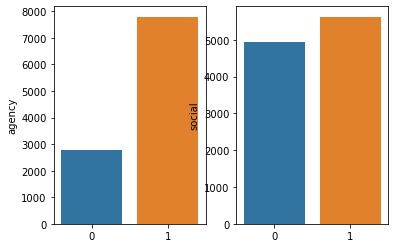

In [8]:

fig, ax =plt.subplots(1,2)
sns.barplot(df_train['agency'].value_counts().index, df_train['agency'].value_counts(), ax=ax[0])
sns.barplot(df_train['social'].value_counts().index, df_train['social'].value_counts(),  ax=ax[1])
fig.show()

As above, the distribution for the agency class is imbalanced, thus leading to the discussion for imbalanced classification if necessary.

3. Number of words in a "moment" for agency classification
The detailed exploration on agency.


In [9]:
# WORD-COUNT
df_train['word_count'] = df_train['moment'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['agency']=="yes"]['word_count'].mean())
print(df_train[df_train['agency']=="no"]['word_count'].mean())

nan
nan


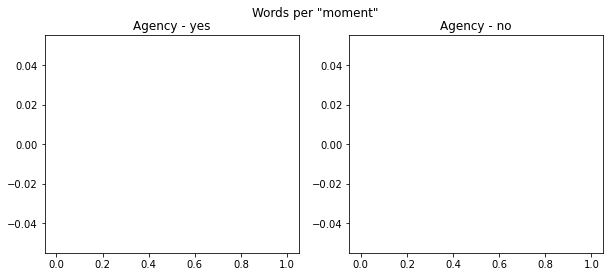

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['agency']=='yes']['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Agency - yes')
train_words=df_train[df_train['agency']=='no']['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Agency - no')
fig.suptitle('Words per "moment"')
plt.show()

The distribution of both 'yes' and 'no' classes of agency is the same, which will contribute to the further discussion for imbalanced class.

<AxesSubplot:xlabel='word numbers', ylabel='# of moments'>

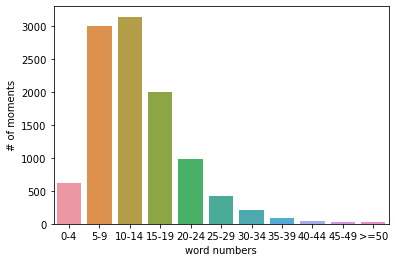

In [11]:
length_order = ["0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", \
                "40-44", "45-49", ">=50"]
length_category = df_train['word_count'].apply(lambda x: length_order[min(10, int(x/5))])
length_counts = pd.DataFrame(length_category.value_counts()).reset_index()
length_counts.columns = ['word numbers', '# of moments']

sns.barplot(x='word numbers', y='# of moments', data=length_counts, order=length_order)


##Data Cleaning

In [12]:
# Missing values
df_train.isna().sum()

hmid           0
moment         0
concepts       0
agency         0
social         0
age            9
country       22
gender         6
married       15
parenthood     9
reflection     0
word_count     0
dtype: int64

As 9 missing values in "age", 22 in "country", 6 in "gender", 15 in marriage condition, 9 in "parenthood", and None in others.

In [13]:
# convert the original data to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower()
    text=text.strip()
    text=re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text)
    return text

# Lexicon - based
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)#LEMMATIZATION
# Initialize the lemmatizer

# #2. STEMMING
# # Initialize the stemmer
# snow = SnowballStemmer('english')
# def stemming(string):
#     a=[snow.stem(i) for i in word_tokenize(string) ]
#     return " ".join(a)

# 3.
wl = WordNetLemmatizer()
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN# Tokenize the sentence
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [14]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['moment'].apply(lambda x: finalpreprocess(x))
df_train.head()

df_test['clean_text'] = df_test['moment'].apply(lambda x: finalpreprocess(x))
df_test.head()

,hmid,moment,reflection,age,country,gender,duration,married,parenthood,concepts,agency,social,clean_text
0,0,I was able to spend the day with my fiance sho...,24h,28,USA,m,all_day_im_still_feeling_it,single,n,shopping|family|romance,1,0,able spend day fiance shopping yesterday
1,1,I was able to play with my cat.,24h,28,USA,m,at_least_one_hour,single,n,animals,1,0,able play cat
2,2,I was able to clean my room and gold my laundry.,24h,28,USA,m,at_least_one_hour,single,n,0,1,0,able clean room gold laundry
3,3,I spend the day at a party on the beach and I ...,24h,24,USA,m,half_a_day,single,n,vacation|party|weather,1,1,spend day party beach happy see friend miss be...
4,4,My cat greeting me when I got home from work -...,24h,24,USA,m,half_a_day,single,n,animals,0,0,cat greet get home work sweet cute loving


In [15]:
# df_c = df_train[["hmid", "agency", "social", "clean_text"]]
# df_c_t = df_test[["hmid", "agency", "social", "clean_text"]]
#
# df_c.to_csv('/home/amber/Documents/NLP_Assignments/A2/claff-happydb/docs/cleaned.csv')
# df_c_t.to_csv('/home/amber/Documents/NLP_Assignments/A2/claff-happydb/docs/cleaned_t.csv')


In [16]:
# df_train= pd.read_csv('/home/amber/Documents/NLP_Assignments/A2/claff-happydb/docs/cleaned.csv', encoding='cp1252')
# df_test=pd.read_csv('/home/amber/Documents/NLP_Assignments/A2/claff-happydb/docs/cleaned_t.csv', encoding='cp1252')

Embedded - Word2Vec

In [17]:
# create Word2vec
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
# df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
# model = Word2Vec(df_train['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
# # #if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it
# #
# w2v = dict(zip(model.wv.index2word, model.wv.vectors))  #combination of word and its vector
#
# #for converting sentence to vectors/numbers from word vectors result by Word2Vec
# class MeanEmbeddingVectorizer(object):
#     def __init__(self, word2vec):
#         self.word2vec = word2vec
#         # if a text is empty we should return a vector of zeros
#         # with the same dimensionality as all the other vectors
#         self.dim = len(next(iter(word2vec.values())))
#
#     def fit(self, X, y):
#         return self
#
#     def transform(self, X):
#         return np.array([
#             np.mean([self.word2vec[w] for w in words if w in self.word2vec]
#                     or [np.zeros(self.dim)], axis=0)
#             for words in X
#         ])


In [18]:
df_test

,hmid,moment,reflection,age,country,gender,duration,married,parenthood,concepts,agency,social,clean_text
0,0,I was able to spend the day with my fiance sho...,24h,28,USA,m,all_day_im_still_feeling_it,single,n,shopping|family|romance,1,0,able spend day fiance shopping yesterday
1,1,I was able to play with my cat.,24h,28,USA,m,at_least_one_hour,single,n,animals,1,0,able play cat
2,2,I was able to clean my room and gold my laundry.,24h,28,USA,m,at_least_one_hour,single,n,0,1,0,able clean room gold laundry
3,3,I spend the day at a party on the beach and I ...,24h,24,USA,m,half_a_day,single,n,vacation|party|weather,1,1,spend day party beach happy see friend miss be...
4,4,My cat greeting me when I got home from work -...,24h,24,USA,m,half_a_day,single,n,animals,0,0,cat greet get home work sweet cute loving
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17210,21892,My wife and I went for a hike last week and we...,3m,34,USA,m,half_a_day,married,n,romance|exercise|family,1,1,wife go hike last week become amazingly inspire
17211,21893,I finally hit platinum rank in Overwatch.,3m,34,USA,m,at_least_one_hour,married,n,entertainment,1,0,finally hit platinum rank overwatch
17212,21897,One of my long-time friends and I finally ackn...,3m,34,USA,m,all_day_im_still_feeling_it,single,n,romance,1,1,one long time friend finally acknowledge love ...
17213,21898,I earned a professional certification.,3m,34,USA,m,half_a_day,single,n,career|education,1,0,earn professional certification


TRAIN TEST SPLITTING OF LABELLED DATASET

In [19]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION

# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
#X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"], df_train["agency"],test_size=0.2,shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"], df_train["agency"],test_size=0.2,shuffle=True)
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(df_train["clean_text"], df_train["social"],test_size=0.2,shuffle=True)
X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(df_train["clean_text"],pd.DataFrame({'agency':df_train["agency"],'social':df_train["social"]}),test_size=0.2,shuffle=True)
# print(y_train_s)
#print(len(X_train), len(y_train))


In [20]:

# X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
# X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec
#
# X_train_tok_s= [nltk.word_tokenize(i) for i in X_train_s]  #for word2vec
# X_val_tok_s= [nltk.word_tokenize(i) for i in X_val_s]      #for word2vec
#
# X_train_tok_m= [nltk.word_tokenize(i) for i in X_train_s]  #for word2vec
# X_val_tok_m= [nltk.word_tokenize(i) for i in X_val_s]      #for word2vec

# #TF-IDF
# # Convert x_train to vector since model can only run on numbers and not words- Fit and transform
# tfidf_vectorizer = TfidfVectorizer(use_idf=True)
# X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will
# # #change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
# # #fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without
# # #it, and the have compatible
# X_train_vectors_tfidf_s = tfidf_vectorizer.fit_transform(X_train_s) #tfidf runs on non-tokenized sentences unlike word2vec
# X_val_vectors_tfidf_s = tfidf_vectorizer.transform(X_val_s)
#
# X_train_vectors_tfidf_m = tfidf_vectorizer.fit_transform(X_train_s) #tfidf runs on non-tokenized sentences unlike word2vec
# X_val_vectors_tfidf_m = tfidf_vectorizer.transform(X_val_s)

#Word2vec
# Fit and transform
# modelw = MeanEmbeddingVectorizer(w2v)
# X_train_vectors_w2v = modelw.transform(X_train_tok)
# X_val_vectors_w2v = modelw.transform(X_val_tok)
#
# X_train_vectors_w2v_s = modelw.transform(X_train_tok_s)
# X_val_vectors_w2v_s = modelw.transform(X_val_tok_s)
#
# X_train_vectors_w2v_m = modelw.transform(X_train_tok_m)
# X_val_vectors_w2v_m = modelw.transform(X_val_tok_m)

In [21]:
df_train.head()

,hmid,moment,concepts,agency,social,age,country,gender,married,parenthood,reflection,word_count,clean_text
0,27674,I was happy when my son got 90% marks in his e...,education|family,0,1,29.0,IND,m,married,y,24h,12,happy son get mark examination
1,27685,went to movies with my friends it was fun,entertainment,1,1,29.0,IND,m,single,y,24h,9,go movie friend fun
2,27691,A hot kiss with my girl friend last night made...,romance,1,1,25.0,IND,m,married,y,24h,12,hot kiss girl friend last night make day
3,27701,My son woke me up to a fantastic breakfast of ...,family|food,0,1,79,USA,f,widowed,y,24h,17,son wake fantastic breakfast egg special hambu...
4,27712,My older daughter keeps patting my younger dau...,family,0,1,30,USA,f,married,y,24h,9,old daughter keep pat young daughter head


Model Design

1. [20 marks] Train a simple classifier, as a baseline. It could be a traditional classifier (SVM, Random Forest, NB, or other), or using some pre-trained models based on deep learning (pre-trained word embeddings or other models).

1). Logistic Regression with TF-IDF
Start with the simplest one - Logistic Regression.

In [22]:
# def LRwTFIDF(X_val):
#     lr=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
#     lr.fit(X_train_vectors_tfidf, y_train)  #model
#
#     #Predict y value for test dataset
#     y_predict = lr.predict(X_val)
#     y_prob = lr.predict_proba(X_val)[:,1]
#     return y_predict,y_prob
#
# lr_y_predict,lr_y_prob = LRwTFIDF(X_val_vectors_tfidf)
# print(classification_report(y_val,lr_y_predict))
# print('Confusion Matrix:',confusion_matrix(y_val, lr_y_predict))
#
# fpr, tpr, thresholds = roc_curve(y_val, lr_y_prob)
# roc_auc = auc(fpr, tpr)
# print('AUC:', roc_auc)


In [23]:
# def LRwTFIDF(X_val):
#     lr=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
#
#     lr.fit(X_train_vectors_tfidf_s, y_train_s)  #model
#
#     #Predict y value for test dataset
#     y_predict = lr.predict(X_val)
#     y_prob = lr.predict_proba(X_val)[:,1]
#     return y_predict,y_prob
#
# lr_y_predict,lr_y_prob = LRwTFIDF(X_val_vectors_tfidf_s)
# print(classification_report(y_val_s,lr_y_predict))
# print('Confusion Matrix:',confusion_matrix(y_val_s, lr_y_predict))
#
# fpr, tpr, thresholds = roc_curve(y_val_s, lr_y_prob)
# roc_auc = auc(fpr, tpr)
# print('AUC:', roc_auc)

In [24]:
# import numpy as np
# from sklearn.datasets import load_linnerud
# from sklearn.multioutput import MultiOutputClassifier
# import xgboost as xgb
# from sklearn.linear_model import Ridge
# #X, y = load_linnerud(return_X_y=True)
# # create XGBoost instance with default hyper-parameters
# from skmultilearn.problem_transform import BinaryRelevance
# #binary_rel_clf = BinaryRelevance(MultinomialNB())
# binary_rel_clf = BinaryRelevance(LogisticRegression(solver = 'lbfgs'))
# binary_rel_clf.fit(X_train_vectors_tfidf_m,y_train_m)
# # BinaryRelevance(classifier=MultinomialNB(alpha=1.0, class_prior=None,
# #                                          fit_prior=True),
# #                 require_dense=[True, True])
# BinaryRelevance(classifier=LogisticRegression(random_state= 0 ))
# br_prediction = binary_rel_clf.predict(X_val_vectors_tfidf_m)
# accuracy_score(y_val_m,br_prediction)
#
# print(classification_report(y_val_m,br_prediction))
# print(accuracy_score(y_val_m,br_prediction))
#

# fpr, tpr, thresholds = roc_curve(y_val_s, y_prob)
# roc_auc = auc(fpr, tpr)
# print('AUC:', roc_auc)

2). Naive Bayes with TF-IDF
It's a probabilistic classifier that makes use of Bayes' Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.


In [25]:
# #FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
# #It's a probabilistic classifier that makes use of Bayes' Theorem, a rule that uses probability to make predictions basDATAed on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.
# def NBwTFIDF(X_val):
#     nb_tfidf = MultinomialNB()
#     nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model
#
#     #Predict y value for test dataset
#     y_predict = nb_tfidf.predict(X_val)
#     y_prob = nb_tfidf.predict_proba(X_val)[:,1]
#     return y_predict,y_prob
#
# NB_y_predict, NB_y_prob = NBwTFIDF(X_val_vectors_tfidf)
# print(classification_report(y_val,NB_y_predict))
# print('Confusion Matrix:',confusion_matrix(y_val, NB_y_predict))
#
# fpr, tpr, thresholds = roc_curve(y_val, NB_y_prob)
# roc_auc = auc(fpr, tpr)
# print('AUC:', roc_auc)

In [26]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
#It's a probabilistic classifier that makes use of Bayes' Theorem, a rule that uses probability to make predictions basDATAed on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.
# def NBwTFIDF(X_val):
#     nb_tfidf = MultinomialNB()
#     nb_tfidf.fit(X_train_vectors_tfidf_s, y_train_s)  #model
#
#     #Predict y value for test dataset
#     y_predict = nb_tfidf.predict(X_val)
#     y_prob = nb_tfidf.predict_proba(X_val)[:,1]
#     return y_predict,y_prob
#
# NB_y_predict, NB_y_prob = NBwTFIDF(X_val_vectors_tfidf_s)
# print(classification_report(y_val_s,NB_y_predict))
# print('Confusion Matrix:',confusion_matrix(y_val_s, NB_y_predict))
#
# fpr, tpr, thresholds = roc_curve(y_val_s, NB_y_prob)
# roc_auc = auc(fpr, tpr)
# print('AUC:', roc_auc)

3). Logistic Regression with Word2Vec

In [27]:
# #FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
# def LRwW2V(X_val):
#     lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
#     lr_w2v.fit(X_train_vectors_w2v, y_train)  #model
#
#     #Predict y value for test dataset
#     y_predict = lr_w2v.predict(X_val)
#     y_prob = lr_w2v.predict_proba(X_val)[:,1]
#     return y_predict,y_prob
#
# lr_w2v_predict,lr_w2v_prob = LRwW2V(X_val_vectors_w2v)
# print(classification_report(y_val,lr_w2v_predict))
# print('Confusion Matrix:',confusion_matrix(y_val, lr_w2v_predict))
#
# fpr, tpr, thresholds = roc_curve(y_val, lr_w2v_prob)
# roc_auc = auc(fpr, tpr)
# print('AUC:', roc_auc)


In [28]:

# def NBwW2V(X_val):
#     nb_w2v = MultinomialNB()
#     nb_w2v.fit(X_train_vectors_w2v, y_train)  #model
#
#     #Predict y value for test dataset
#     y_predict = nb_w2v.predict(X_val)
#     y_prob = nb_w2v.predict_proba(X_val)[:,1]
#     return y_predict,y_prob
# NB_w2v_predict, NB_w2v_prob = NBwW2V(X_val_vectors_w2v)
# print(classification_report(y_val,NB_w2v_predict))
# print('Confusion Matrix:',confusion_matrix(y_val, NB_w2v_predict))
#
# fpr, tpr, thresholds = roc_curve(y_val, NB_w2v_prob)
# roc_auc = auc(fpr, tpr)
# print('AUC:', roc_auc)

Tokenized with Bert

In [29]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, model_max_length=512)
# tokenized_texts
#df_train['clean_text_bert']=[tokenizer.tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence

##As BERT can only accept/take as input only 512 tokens at a time, we must specify the truncation parameter to True. The add special tokens parameter is just for BERT to add tokens like the start, end, [SEP], and [CLS] tokens. Return_tensors = “pt” is just for the tokenizer to return PyTorch tensors.
# for i in df_train["clean_text"]:
#     print(i)
#     encoding = tokenizer.encode_plus(i , add_special_tokens = True,    truncation = True, padding = "max_length", return_attention_mask = True, return_tensors = "pt")

##The main difference between tokenizer.encode_plus() and tokenizer.encode() is that tokenizer.encode_plus() returns more information. Specifically, it returns the actual input ids, the attention masks, and the token type ids, and it returns all of these in a dictionary. tokenizer.encode() only returns the input ids, and it returns this either as a list or a tensor depending on the parameter, return_tensors = “pt”.
# encoding = tokenizer.encode_plus([i for i in df_train["clean_text"]] , add_special_tokens = True,    truncation = True, padding = "max_length", return_attention_mask = True, return_tensors = "pt")



In [30]:
# Concatenate train data and test data
all_text = np.concatenate([df_train.moment.values, df_test.moment.values])

# Encode our concatenated data
encoded_text = [tokenizer.encode(i, add_special_tokens=True) for i in all_text]

# Find the maximum length
max_len = max([len(i) for i in encoded_text])
print('Max length: ', max_len)

Max length:  155


In [31]:
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []
    MAX_LEN = 128

    # For every sentence...
    for i in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text = i ,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # # Convert lists to tensors
    # input_ids = torch.tensor(input_ids)
    # attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks



In [32]:
#prepare input under agency/sociality/combined class
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

train_inputs_s, train_masks_s = preprocessing_for_bert(X_train_s)
val_inputs_s, val_masks_s = preprocessing_for_bert(X_val_s)

train_inputs_m, train_masks_m = preprocessing_for_bert(X_train_m)
val_inputs_m, val_masks_m = preprocessing_for_bert(X_val_m)




In [33]:
test_inputs, test_masks = preprocessing_for_bert(df_test['clean_text'])

Basic classifiers under Bert tokenizer

In [34]:
# #FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
# def LRwBERT(X_val):
#     lr_bert=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
#     lr_bert.fit(train_inputs, y_train)  #model
#
#     #Predict y value for test dataset
#     y_predict = lr_bert.predict(X_val)
#     y_prob = lr_bert.predict_proba(X_val)[:,1]
#     return y_predict,y_prob
#
# lr_bert_predict,lr_bert_prob = LRwBERT(val_inputs)
# print(classification_report(y_val,lr_bert_predict))
# print('Confusion Matrix:',confusion_matrix(y_val, lr_bert_predict))
#
# fpr, tpr, thresholds = roc_curve(y_val, lr_bert_prob)
# roc_auc = auc(fpr, tpr)
# print('AUC:', roc_auc)


In [35]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
# def LRwBERT(X_val):
#     lr_bert=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
#     lr_bert.fit(train_inputs_s, y_train_s)  #model
#
#     #Predict y value for test dataset
#     y_predict = lr_bert.predict(X_val)
#     y_prob = lr_bert.predict_proba(X_val)[:,1]
#     return y_predict,y_prob
#
# lr_bert_predict,lr_bert_prob = LRwBERT(val_inputs_s)
# print(classification_report(y_val_s,lr_bert_predict))
# print('Confusion Matrix:',confusion_matrix(y_val_s, lr_bert_predict))
#
# fpr, tpr, thresholds = roc_curve(y_val_s, lr_bert_prob)
# roc_auc = auc(fpr, tpr)
# print('AUC:', roc_auc)

In [36]:
# def NBwBERT(X_val):
#     nb_tfidf = MultinomialNB()
#     nb_tfidf.fit(train_inputs, y_train)  #model
#
#     #Predict y value for test dataset
#     y_predict = nb_tfidf.predict(X_val)
#     y_prob = nb_tfidf.predict_proba(X_val)[:,1]
#     return y_predict,y_prob
# nb_bert_predict,nb_bert_prob = NBwW2V(val_inputs)
# print(classification_report(y_val,nb_bert_predict))
# print('Confusion Matrix:',confusion_matrix(y_val, nb_bert_predict))
#
# fpr, tpr, thresholds = roc_curve(y_val, nb_bert_prob)
# roc_auc = auc(fpr, tpr)
# print('AUC:', roc_auc)

In [37]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32
print(type(y_train))

datasets = {
    'train_a': TensorDataset(torch.tensor(train_inputs), torch.tensor(train_masks), torch.tensor(y_train.values)),
    'val_a': TensorDataset(torch.tensor(val_inputs), torch.tensor(val_masks), torch.tensor(y_val.values)),
    'train_s': TensorDataset(torch.tensor(train_inputs_s), torch.tensor(train_masks_s), torch.tensor(y_train_s.values)),
    'val_s': TensorDataset(torch.tensor(val_inputs_s), torch.tensor(val_masks_s), torch.tensor(y_val_s.values)),
    'test': TensorDataset(torch.tensor(test_inputs), torch.tensor(test_masks), torch.tensor(df_test['social'].values)),

}
print(datasets['train_a'])
dataloaders = {
    'train_a': DataLoader(datasets['train_a'], batch_size=batch_size),
    'val_a': DataLoader(datasets['val_a'], batch_size=batch_size),
    'train_s': DataLoader(datasets['train_s'], batch_size=batch_size),
    'val_s': DataLoader(datasets['val_s'], batch_size=batch_size),
    'test': DataLoader(datasets['test'], batch_size=batch_size),
}

<class 'pandas.core.series.Series'>


2. [30 marks] Train an advanced classifier based on deep learning, such as fine-tuning BERT. You can try predicting both labels independently, or in a multi-task manner. Use part of the training data for validation, and keep aside the test data when choosing the best model.


In [38]:
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False


    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [39]:

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")


running on the GPU


In [40]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(test_loader, epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(test_loader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler


In [41]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []


    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        input_ids, attn_mask, labels = tuple(t.to(device) for t in batch)


        # Compute logits
        with torch.no_grad():
            logits = model(input_ids, attn_mask)

        # Compute loss
        loss = loss_fn(logits, labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()


        # Calculate the accuracy rate
        accuracy = (preds == labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)


    # Compute the average accuracy and loss over the validation set.

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)


    return val_loss, val_accuracy


#import random
import time
import torch.nn as nn
import random 
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            input_ids, attn_mask,labels = tuple(t.to(device) for t in batch)


            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(input_ids, attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()


            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")


In [42]:

# For agency prediction
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(dataloaders['train_a'], epochs=2)
train(bert_classifier, dataloaders['train_a'], dataloaders['val_a'], epochs=4, evaluation=True)


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.580162   |     -      |     -     |   9.29   
   1    |   40    |   0.467818   |     -      |     -     |   8.91   
   1    |   60    |   0.386101   |     -      |     -     |   8.97   
   1    |   80    |   0.383883   |     -      |     -     |   9.02   
   1    |   100   |   0.385418   |     -      |     -     |   9.07   
   1    |   120   |   0.434022   |     -      |     -     |   9.13   
   1    |   140   |   0.368804   |     -      |     -     |   9.14   
   1    |   160   |   0.379477   |     -      |     -     |   9.17   
   1    |   180   |   0.346050   |     -      |     -     |   9.30   
   1    |   200   |   0.363576   |     -      |     -     |   9.43   
   1    |   220   |   0.348788   |     -      |     -     |   9.46   
   1    |   240   |   0.354708   |     -      |     -     |   9.49   


In [43]:
# torch.cuda.memory_stats()

In [44]:
print(device)

cuda:0


In [45]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []


    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [46]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [47]:
torch.cuda.empty_cache()

AUC: 0.9077
Accuracy: 85.42%


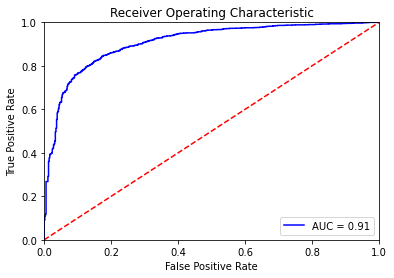

              precision    recall  f1-score   support

           0       0.71      0.72      0.71       531
           1       0.91      0.90      0.90      1581

    accuracy                           0.85      2112
   macro avg       0.81      0.81      0.81      2112
weighted avg       0.86      0.85      0.85      2112



In [48]:
probs_val = bert_predict(bert_classifier,  dataloaders['val_a'])

# Evaluate the Bert classifier
evaluate_roc(probs_val, y_val)
# Get predictions from the probabilities
threshold = 0.5
preds_val = np.where(probs_val[:, 1] > threshold, 1, 0)

print(classification_report(preds_val, y_val ))

Number of tweets predicted non-negative:  12449
AUC: 0.8865
Accuracy: 83.04%


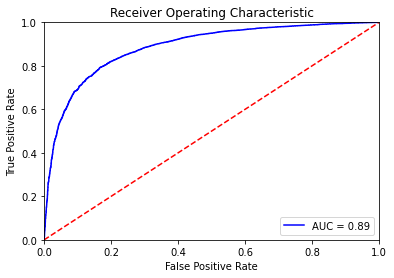

              precision    recall  f1-score   support

           0       0.68      0.72      0.70      4766
           1       0.89      0.87      0.88     12449

    accuracy                           0.83     17215
   macro avg       0.79      0.80      0.79     17215
weighted avg       0.83      0.83      0.83     17215



In [49]:
# Compute predicted probabilities on the test set
probs_test = bert_predict(bert_classifier, dataloaders['test'])

# Get predictions from the probabilities
threshold = 0.5
preds_test = np.where(probs_test[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds_test.sum())

# Evaluate the Bert classifier
evaluate_roc(probs_test, df_test['agency'] )
print(classification_report(preds_test, df_test['agency'] ))

In [50]:
# For sociality
set_seed(42)    # Set seed for reproducibility
bert_classifier_s, optimizer, scheduler = initialize_model(dataloaders['train_s'],epochs=10)
train(bert_classifier_s, dataloaders['train_s'], dataloaders['val_s'], epochs=4, evaluation=True)


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.537596   |     -      |     -     |   9.93   
   1    |   40    |   0.337600   |     -      |     -     |   9.51   
   1    |   60    |   0.318566   |     -      |     -     |   9.50   
   1    |   80    |   0.328328   |     -      |     -     |   9.53   
   1    |   100   |   0.274833   |     -      |     -     |   9.50   
   1    |   120   |   0.243568   |     -      |     -     |   9.51   
   1    |   140   |   0.261125   |     -      |     -     |   9.51   
   1    |   160   |   0.257954   |     -      |     -     |   9.52   
   1    |   180   |   0.263567   |     -      |     -     |   9.51   
   1    |   200   |   0.239000   |     -      |     -     |   9.52   
   1    |   220   |   0.244903   |     -      |     -     |   9.50   
   1    |   240   |   0.266653   |     -      |     -     |   9.49   


AUC: 0.9582
Accuracy: 90.53%


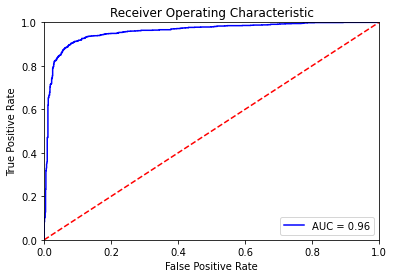

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       967
           1       0.92      0.90      0.91      1145

    accuracy                           0.91      2112
   macro avg       0.90      0.91      0.90      2112
weighted avg       0.91      0.91      0.91      2112



In [51]:
probs_val_s = bert_predict(bert_classifier_s,  dataloaders['val_s'])

# Evaluate the Bert classifier
evaluate_roc(probs_val_s, y_val_s)
# Get predictions from the probabilities
threshold = 0.5
preds_val_s = np.where(probs_val_s[:, 1] > threshold, 1, 0)

print(classification_report(preds_val_s, y_val_s ))


AUC: 0.9578
Accuracy: 90.01%


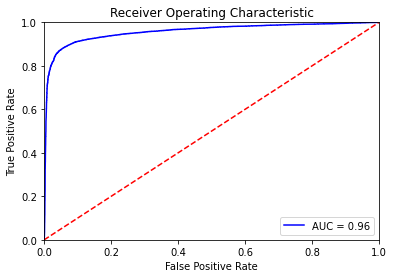

Number of tweets predicted non-negative:  9989
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      7226
           1       0.92      0.90      0.91      9989

    accuracy                           0.90     17215
   macro avg       0.90      0.90      0.90     17215
weighted avg       0.90      0.90      0.90     17215



In [52]:
# Compute predicted probabilities on the test set
probs_test_s = bert_predict(bert_classifier_s, dataloaders['test'])
# Evaluate the Bert classifier
evaluate_roc(probs_test_s, df_test['social'] )
# Get predictions from the probabilities
preds_test_s = np.where(probs_test_s[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds_test_s.sum())


print(classification_report(preds_test_s, df_test['social'] ))

In [55]:
output = df_test[preds_test==1]
list(output.sample(20).moment)


['I sold a t shirt on ebay for $20 for which I paid only 99cents.',
 'I was able to apply for the job I have been wanting.',
 'When I got my first cna job',
 'I got mail and it was a suprise walmart beauty box with 99% things of samples i would use.',
 'I had steak for dinner.',
 'I met my oversea boyfriend',
 "I have gotten accepted to my dream university where I can obtain my second bachelor's degree in a field I'm passionate about.",
 'watch a realy good movie',
 'going to tour with my frends',
 'I was able to get a good sleep after staying up all night.',
 'It made me happy to begin a new day today as yesterday was not a good one.',
 'Talking to my husband when he got off from a long day of work, and enjoying dinner together.',
 'two days ago I helped a cat that was abandoned in the street I took it to my house and there I gave him food and then take him to the veterinary',
 'I managed to complete my workout and set a new personal record.',
 'Going on a date with what would be my n

,hmid,agency,social,agency_preds,social_preds
0,0,1,0,1,1
1,1,1,0,0,1
2,2,1,0,0,1
3,3,1,1,1,1
4,4,0,0,0,0
...,...,...,...,...,...
17210,21892,1,1,1,1
17211,21893,1,0,0,1
17212,21897,1,1,1,0
17213,21898,1,0,0,1


In [64]:
df_t = df_test[["hmid"]]
df_t.to_csv('/home/amber/Documents/NLP_Assignments/A2/output/output.txt', index=None, sep=' ')

In [65]:
df_t['agency_label'] = preds_test
df_t['social_label'] = preds_test_s

<ipython-input-65-e33b5b74a6b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['agency_preds'] = preds_test
<ipython-input-65-e33b5b74a6b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['social_preds'] = preds_test_s


In [66]:
df_t

,hmid,agency_preds,social_preds
0,0,1,1
1,1,1,0
2,2,1,0
3,3,1,1
4,4,0,0
...,...,...,...
17210,21892,1,1
17211,21893,1,0
17212,21897,0,1
17213,21898,1,0


In [56]:
# #Testing it on new dataset with the best model
# #df_test=pd.read_csv('test.csv')  #reading the data
# df_test['clean_text'] = df_test['moment'].apply(lambda x: finalpreprocess(x)) #preprocess the data
# X_test=df_test['clean_text']
# X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
# y_predict,y_prob = LRwTFIDF(X_vector)
# df_test['predict_prob']= y_prob
# df_test['predict']= y_predict
# print(df_test.head())
# final=df_test['predict'].reset_index(drop=True)
# final.to_csv('submission.csv')